In [123]:
import pandas as pd
import numpy as np
#https://github.com/YuxinWenRick/hard-prompts-made-easy

In [124]:
! pip install bpemb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [125]:
import torch


In [126]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

! pip install git+https://github.com/openai/CLIP.git
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import clip
import torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-hpu0pisi
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-hpu0pisi
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [127]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Import CLIP
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

In [ ]:
tokenizer = clip.tokenize
token_embedding = clip_model.token_embedding

In [ ]:
import torchvision.transforms as T
from PIL import Image

transform = T.ToPILImage()

# Helpers

In [ ]:
def compute_loss(a, b, c):
    a = 1 - torch.mean(a)
    b = 1 - torch.mean(b)
    c = 1 - torch.mean(c)
  
    loss = (a + b - c)

    return loss
     

In [ ]:
def compute_simalirities_images(text, images):
    cos_sim_1 = 0
    for image in images:
      cos_sim_1 += torch.nn.functional.cosine_similarity(text.unsqueeze(1), image.unsqueeze(0), dim=-1)

    return cos_sim_1/len(images)

In [ ]:
def custom_encode_text(clip_model, text):
    x = clip_model.token_embedding(text).type(clip_model.dtype)  # [batch_size, n_ctx, d_model]
    #'''
    x = x + clip_model.positional_embedding.type(clip_model.dtype)
    x = x.permute(1, 0, 2)  # NLD -> LND
    x = clip_model.transformer(x)
    x = x.permute(1, 0, 2)  # LND -> NLD
    x = clip_model.ln_final(x).type(clip_model.dtype)

    # x.shape = [batch_size, n_ctx, transformer.width]
    # take features from the eot embedding (eot_token is the highest number in each sequence)
    #x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ clip_model.text_projection

    x = x @ clip_model.text_projection
    # X is now [1,77,512] instead of [1,512]
    return x

# Load and encode images

# With 1 different word

In [156]:
import os

text_1 = "a bird with a on a branch shovel"
image_1_original = []
image_2_original = []
count = 0
for filename in os.listdir("/content/drive/MyDrive/CUB_200_2011/CUB_200_2011/images/165.Chestnut_sided_Warbler/"):
  if count == 10:
    break
  image_1_original.append(Image.open("/content/drive/MyDrive/CUB_200_2011/CUB_200_2011/images/165.Chestnut_sided_Warbler/{}".format(filename)))
  count+=1


count = 0
text_2 = "a bird with a on a branch brick"
for filename in os.listdir("/content/drive/MyDrive/Birds/CUB_200_2011/images/061.Heermann_Gull/"):
  if count == 10:
    break
  image_2_original.append(Image.open("/content/drive/MyDrive/Birds/CUB_200_2011/images/061.Heermann_Gull/{}".format(filename)))
  count+=1


In [157]:
# Tokenize text
text_1 = tokenizer([text_1],truncate=True).to(device)

text_2 = tokenizer([text_2],truncate=True).to(device)

In [158]:
# Preprocess images
image_1 = []
image_2 = []
for image in image_1_original:
  image_1.append(preprocess(image).unsqueeze(0).to(device))

for image in image_2_original:
  image_2.append(preprocess(image).unsqueeze(0).to(device))

In [159]:
torch.set_grad_enabled(True)

# Encode text 1
text_1_embed = custom_encode_text(clip_model, text_1).detach()
text_1_embed.requires_grad_()

# Encode text 2
text_2_embed = custom_encode_text(clip_model, text_2).detach()
text_2_embed.requires_grad_()


# Encode all image 1
image_1_embed = []
for image in image_1: 
  image_embed = clip_model.encode_image(image).detach()
  image_1_embed.append(image_embed)

# Encode all image 2
image_2_embed = []
for image in image_2: 
  image_embed = clip_model.encode_image(image).detach()
  image_2_embed.append(image_embed)

In [160]:
text_1_embed_dim =  torch.tensor(text_1_embed[0,8]).clone().requires_grad_()
text_2_embed_dim =  torch.tensor(text_2_embed[0,8]).clone().requires_grad_()

<ipython-input-160-a0b5299388a6>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text_1_embed_dim =  torch.tensor(text_1_embed[0,8]).clone().requires_grad_()
<ipython-input-160-a0b5299388a6>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text_2_embed_dim =  torch.tensor(text_2_embed[0,8]).clone().requires_grad_()


In [161]:
# Initialize optimizer
optimizer = torch.optim.SGD([text_1_embed_dim, text_2_embed_dim], lr=0.5)

sim_1 = []
sim_2 = []
sim_3 = []
losses = []

# Iterations
num_epochs = 200

text_1_embed = torch.tensor(text_1_embed - text_1_embed_dim).clone().requires_grad_(True)
text_2_embed = torch.tensor(text_2_embed - text_2_embed_dim).clone().requires_grad_(True)

for epoch in range(num_epochs):
  text_1_embed = torch.tensor(text_1_embed + text_1_embed_dim).clone().detach().requires_grad_(True)
  text_2_embed = torch.tensor(text_2_embed + text_2_embed_dim).clone().detach().requires_grad_(True)
  optimizer.zero_grad()

  # Compute similarities
  cos_sim_1 = compute_simalirities_images(text_1_embed, image_1_embed)
  cos_sim_2 = compute_simalirities_images(text_2_embed, image_2_embed)
  cos_sim_3 = torch.nn.functional.cosine_similarity(text_1_embed.unsqueeze(1), text_2_embed.unsqueeze(0), dim=-1)
  cos_sim_4 = compute_simalirities_images(text_1_embed, image_2_embed)
  cos_sim_5 = compute_simalirities_images(text_2_embed, image_1_embed)

  # Compute loss
  loss = compute_loss(cos_sim_1, cos_sim_2, cos_sim_3)
  # Backpropagation
  loss.backward()
  if epoch % 100 == 0: 
    print("The loss is for epoch {}: {}".format(epoch, loss))
    print("The similarity between text 1 and image 1 is: {}".format(torch.mean(cos_sim_1[0][0])))
    print("The similarity between text 2 and image 2 is: {}".format(torch.mean(cos_sim_2[0][0])))
    print("The similarity between text 1 and 2 is: {}".format(torch.mean(cos_sim_3[0][0])))
    #print("The similarity between text 1 and image 2 is: {}".format(cos_sim_4.item()))
    #print("The similarity between text 2 and image 1 is: {}".format(cos_sim_5.item()))


  sim_1.append(torch.mean(cos_sim_1[0][0].cpu().detach()))
  sim_2.append(torch.mean(cos_sim_2[0][0].cpu().detach()))
  sim_3.append(torch.mean(cos_sim_3[0][0].cpu().detach()))
  losses.append(torch.mean(loss.cpu().detach()))

  # Optimizer step
  optimizer.step()

<ipython-input-161-b906987c7196>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text_1_embed = torch.tensor(text_1_embed - text_1_embed_dim).clone().requires_grad_(True)
<ipython-input-161-b906987c7196>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text_2_embed = torch.tensor(text_2_embed - text_2_embed_dim).clone().requires_grad_(True)
<ipython-input-161-b906987c7196>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text_1_embed = torch.tensor(text_1_embed + text_1_embed_dim).clone().detach().requires_grad_(True)
<ipython-input-1

The loss is for epoch 0: 1.4707472324371338
The similarity between text 1 and image 1 is: 0.22529830038547516
The similarity between text 2 and image 2 is: 0.2379767745733261
The similarity between text 1 and 2 is: 0.9340223670005798
The loss is for epoch 100: 1.0237176418304443
The similarity between text 1 and image 1 is: 0.21390704810619354
The similarity between text 2 and image 2 is: 0.17382396757602692
The similarity between text 1 and 2 is: 0.4114486575126648


Text(0.5, 1.0, 'Similarity text 1/text 2')

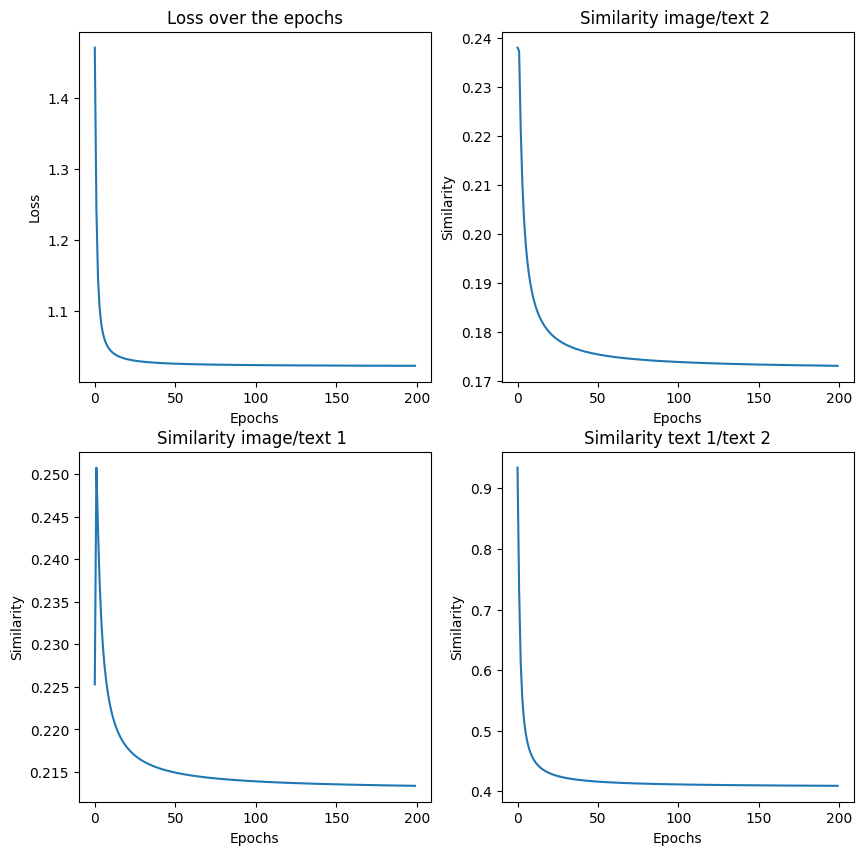

In [162]:
fig, axes = plt.subplots(2,2, figsize = (10,10))
epochs = np.arange(num_epochs)

axes[0][0].plot(epochs, losses)
axes[0][0].set_ylabel("Loss")
axes[0][0].set_xlabel("Epochs")
axes[0][0].set_title("Loss over the epochs")

axes[1][0].plot(epochs, sim_1)
axes[1][0].set_ylabel("Similarity")
axes[1][0].set_xlabel("Epochs")
axes[1][0].set_title("Similarity image/text 1 ")

axes[0][1].plot(epochs, sim_2)
axes[0][1].set_ylabel("Similarity")
axes[0][1].set_xlabel("Epochs")
axes[0][1].set_title("Similarity image/text 2 ")

axes[1][1].plot(epochs, sim_3)
axes[1][1].set_ylabel("Similarity")
axes[1][1].set_xlabel("Epochs")
axes[1][1].set_title("Similarity text 1/text 2")

# With 2 different words

In [180]:
import os

#text_1 = "a bird with a on a branch shovel leaf"
text_1 = "a bird with a on a branch shovel car"
image_1_original = []
image_2_original = []
count = 0
for filename in os.listdir("/content/drive/MyDrive/CUB_200_2011/CUB_200_2011/images/165.Chestnut_sided_Warbler/"):
  if count == 10:
    break
  image_1_original.append(Image.open("/content/drive/MyDrive/CUB_200_2011/CUB_200_2011/images/165.Chestnut_sided_Warbler/{}".format(filename)))
  count+=1


count = 0
#text_2 = "a bird with a on a branch brick tree"
text_2 = "a bird with a on a branch brick mountain"

for filename in os.listdir("/content/drive/MyDrive/Birds/CUB_200_2011/images/061.Heermann_Gull/"):
  if count == 10:
    break
  image_2_original.append(Image.open("/content/drive/MyDrive/Birds/CUB_200_2011/images/061.Heermann_Gull/{}".format(filename)))
  count+=1


In [181]:
# Tokenize text
text_1 = tokenizer([text_1],truncate=True).to(device)

text_2 = tokenizer([text_2],truncate=True).to(device)

In [182]:
# Preprocess images
image_1 = []
image_2 = []
for image in image_1_original:
  image_1.append(preprocess(image).unsqueeze(0).to(device))

for image in image_2_original:
  image_2.append(preprocess(image).unsqueeze(0).to(device))

In [183]:
torch.set_grad_enabled(True)

# Encode text 1
text_1_embed = custom_encode_text(clip_model, text_1).detach()
text_1_embed.requires_grad_()

# Encode text 2
text_2_embed = custom_encode_text(clip_model, text_2).detach()
text_2_embed.requires_grad_()


# Encode all image 1
image_1_embed = []
for image in image_1: 
  image_embed = clip_model.encode_image(image).detach()
  image_1_embed.append(image_embed)

# Encode all image 2
image_2_embed = []
for image in image_2: 
  image_embed = clip_model.encode_image(image).detach()
  image_2_embed.append(image_embed)

In [184]:
text_1_embed_dim_8 =  torch.tensor(text_1_embed[0,8]).clone().requires_grad_()
text_1_embed_dim_9 =  torch.tensor(text_1_embed[0,9]).clone().requires_grad_()
text_2_embed_dim_8 =  torch.tensor(text_2_embed[0,8]).clone().requires_grad_()
text_2_embed_dim_9 =  torch.tensor(text_2_embed[0,9]).clone().requires_grad_()

<ipython-input-184-f8c63f2753a9>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text_1_embed_dim_8 =  torch.tensor(text_1_embed[0,8]).clone().requires_grad_()
<ipython-input-184-f8c63f2753a9>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text_1_embed_dim_9 =  torch.tensor(text_1_embed[0,9]).clone().requires_grad_()
<ipython-input-184-f8c63f2753a9>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text_2_embed_dim_8 =  torch.tensor(text_2_embed[0,8]).clone().requires_grad_()
<ipython-input-184-f8c63f2753a9>:4: UserWarning: To copy cons

In [185]:
# Initialize optimizer
optimizer = torch.optim.SGD([text_1_embed_dim, text_2_embed_dim], lr=0.5)

sim_1 = []
sim_2 = []
sim_3 = []
losses = []

# Iterations
num_epochs = 200

text_1_embed = torch.tensor(text_1_embed - text_1_embed_dim_8 - text_1_embed_dim_9).clone().requires_grad_(True)
text_2_embed = torch.tensor(text_2_embed - text_2_embed_dim_8 - text_2_embed_dim_9).clone().requires_grad_(True)

for epoch in range(num_epochs):
  text_1_embed = torch.tensor(text_1_embed + text_1_embed_dim_8 + text_1_embed_dim_9).clone().detach().requires_grad_(True)
  text_2_embed = torch.tensor(text_2_embed + text_2_embed_dim_8 + text_2_embed_dim_9).clone().detach().requires_grad_(True)
  optimizer.zero_grad()

  # Compute similarities
  cos_sim_1 = compute_simalirities_images(text_1_embed, image_1_embed)
  cos_sim_2 = compute_simalirities_images(text_2_embed, image_2_embed)
  cos_sim_3 = torch.nn.functional.cosine_similarity(text_1_embed.unsqueeze(1), text_2_embed.unsqueeze(0), dim=-1)
  cos_sim_4 = compute_simalirities_images(text_1_embed, image_2_embed)
  cos_sim_5 = compute_simalirities_images(text_2_embed, image_1_embed)

  # Compute loss
  loss = compute_loss(cos_sim_1, cos_sim_2, cos_sim_3)
  # Backpropagation
  loss.backward()
  if epoch % 100 == 0: 
    print("The loss is for epoch {}: {}".format(epoch, loss))
    print("The similarity between text 1 and image 1 is: {}".format(torch.mean(cos_sim_1[0][0])))
    print("The similarity between text 2 and image 2 is: {}".format(torch.mean(cos_sim_2[0][0])))
    print("The similarity between text 1 and 2 is: {}".format(torch.mean(cos_sim_3[0][0])))
    #print("The similarity between text 1 and image 2 is: {}".format(cos_sim_4.item()))
    #print("The similarity between text 2 and image 1 is: {}".format(cos_sim_5.item()))


  sim_1.append(torch.mean(cos_sim_1[0][0].cpu().detach()))
  sim_2.append(torch.mean(cos_sim_2[0][0].cpu().detach()))
  sim_3.append(torch.mean(cos_sim_3[0][0].cpu().detach()))
  losses.append(torch.mean(loss.cpu().detach()))

  # Optimizer step
  optimizer.step()

<ipython-input-185-bc141660e71c>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text_1_embed = torch.tensor(text_1_embed - text_1_embed_dim_8 - text_1_embed_dim_9).clone().requires_grad_(True)
<ipython-input-185-bc141660e71c>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text_2_embed = torch.tensor(text_2_embed - text_2_embed_dim_8 - text_2_embed_dim_9).clone().requires_grad_(True)
<ipython-input-185-bc141660e71c>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text_1_embed = torch.tensor(text_1_embed + text_1_embed_dim_8 + text_

The loss is for epoch 0: 1.4568932056427002
The similarity between text 1 and image 1 is: 0.21790391206741333
The similarity between text 2 and image 2 is: 0.23259137570858002
The similarity between text 1 and 2 is: 0.90738844871521
The loss is for epoch 100: 1.1404281854629517
The similarity between text 1 and image 1 is: 0.23264342546463013
The similarity between text 2 and image 2 is: 0.20809809863567352
The similarity between text 1 and 2 is: 0.5811697244644165


Text(0.5, 1.0, 'Similarity text 1/text 2')

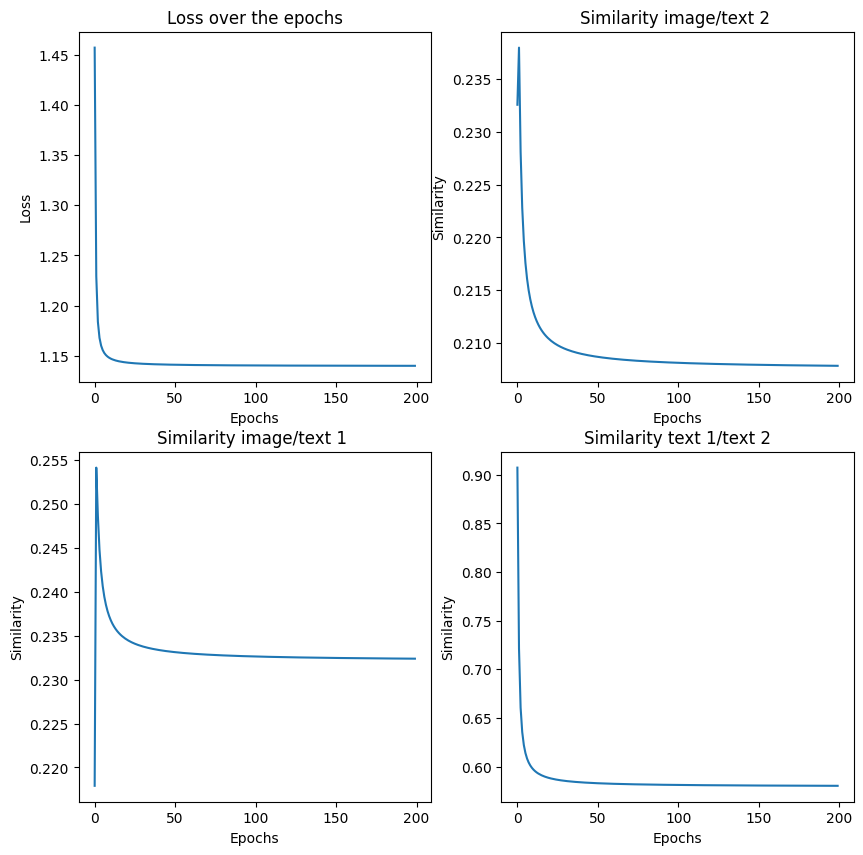

In [186]:
fig, axes = plt.subplots(2,2, figsize = (10,10))
epochs = np.arange(num_epochs)

axes[0][0].plot(epochs, losses)
axes[0][0].set_ylabel("Loss")
axes[0][0].set_xlabel("Epochs")
axes[0][0].set_title("Loss over the epochs")

axes[1][0].plot(epochs, sim_1)
axes[1][0].set_ylabel("Similarity")
axes[1][0].set_xlabel("Epochs")
axes[1][0].set_title("Similarity image/text 1 ")

axes[0][1].plot(epochs, sim_2)
axes[0][1].set_ylabel("Similarity")
axes[0][1].set_xlabel("Epochs")
axes[0][1].set_title("Similarity image/text 2 ")

axes[1][1].plot(epochs, sim_3)
axes[1][1].set_ylabel("Similarity")
axes[1][1].set_xlabel("Epochs")
axes[1][1].set_title("Similarity text 1/text 2")